# <div style="text-align: center"><ins> Value-at-Risk forecasting from a GARCH-type model<ins>
## <div style="text-align: center"> <ins>MNT/USD with Inflation rate as the exogenous variable</ins> </div>

- ### Date: March , 2023
- ### Purpose:Value-at-Risk forecasting of MNT/USD
- ### Data from from Jan 2016 to Dec 22 (GARCH-Model)
- ### Author: Isaac Osei-Mensah



In [62]:
# Import packages
import pandas as pd
import numpy as np
import re
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
import arch
from arch import *
from arch.__future__ import reindexing
from scipy.stats import norm
import warnings

### A. Import Open-source data Jan 16 - Dec 22
 - Souce :[investing.com](https://www.investing.com/currencies/usd-mnt-historical-data)
 - Dataset Used: I collected the daily exchange rate from January 2016 to December 2022
 _________________________________________
 - ### Below is an overview of the head collected
 

In [63]:
# Impoirt data and set date column as index
df =  pd.read_csv("C:/Users/Public/USD_MNT Historical Data_jan16-dec22.csv",
                  index_col=0, parse_dates=True)
# Print the head of the dataset
print(df.head())

            exchange    open    high     low  inflation
date                                                   
2016-01-01    1993.0  1993.0  1993.0  1993.0      0.554
2016-01-04    1991.5  1997.5  1999.5  1989.5      0.554
2016-01-05    1993.5  1995.5  1997.5  1987.5      0.554
2016-01-06    1994.0  1995.0  1998.0  1994.0      0.554
2016-01-07    1994.5  1994.5  1998.5  1986.5      0.554


## <ins>Question 1: </ins>
 - ### Collect one or more daily series of macroeconomic/financial indicator(s) which will influence the log return of MNT/USD from publicly available source. Please describe your choice and explain why
 
## <ins>Response: </ins>
- ## Inflation Rate 
 <p>I collected inflation as a variable that would highly influence the log return of MNT/USD</p>
<p> In flation is a measure of the rate at which prices for goods and services are increasing within an economy. Inflation rate can have a significant impact on the log return of MNT/USD since it affects the purchasing power of the currency, which in turn affects the demand for MNT.</p>
<p> If the inflation rate in Mongolia is higher than the inflation in other countries, the value of the currency will decrease relative to those currencies. This will lead to a weaker MNT/USD exchange rate. On the other hand, if the inflation rate in Mongolia is lower than the inflation in other countries, the value of the currency will increase, leading to a stronger MNT/USD exchange rate.</p>
</p>Investors and traders often monitor inflation rates closely as they can affect the interest rates set by central banks. Central banks may raise interest rates to combat high inflation, which can make the currency more attractive to investors seeking higher yields. Conversely, low inflation rates may lead central banks to lower interest rates to stimulate economic growth, which can lead to a weaker currency.
</p>

## <ins>Question 2: </ins>
   - ### Run a GARCH-type model on the log return of MNT/USD with the series in (1) as the exogenous variable(s) in the mean process

_______________________________________________________________________________________
### CLEAN DATA
- #### Transforms data from USD/MNT to MNT/USD
- #### Data was obtained in USD/MNT format and
- #### Must be inverted to MNT/USD


In [64]:
for j in ['exchange', 'open', 'high', 'low']:
    df[j] = (1/ df[j])
print(df.head())


            exchange      open      high       low  inflation
date                                                         
2016-01-01  0.000502  0.000502  0.000502  0.000502      0.554
2016-01-04  0.000502  0.000501  0.000500  0.000503      0.554
2016-01-05  0.000502  0.000501  0.000501  0.000503      0.554
2016-01-06  0.000502  0.000501  0.000501  0.000502      0.554
2016-01-07  0.000501  0.000501  0.000500  0.000503      0.554


#### Keep only the exchange rate and inflation as variables of interest


In [65]:
df =  df[["exchange", "inflation"]]
print(df.head())


            exchange  inflation
date                           
2016-01-01  0.000502      0.554
2016-01-04  0.000502      0.554
2016-01-05  0.000502      0.554
2016-01-06  0.000502      0.554
2016-01-07  0.000501      0.554


#### Calculate the log returns of the exchange rate

In [66]:

df['log_exchange'] = np.log(df['exchange']).diff()          # Use Numpy to calculate the log returns of the exchange rate
keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)      # Remove any nan or inf values after calculation of log returns
df = df[keep].astype(np.float64)
df =  df*1000                                               # Multiply data by 1000 to avoid warnings when the variance is extremely small 
inflation = df['inflation']
print(df.head())

            exchange  inflation  log_exchange
date                                         
2016-01-04  0.502134      554.0      0.752918
2016-01-05  0.501630      554.0     -1.003764
2016-01-06  0.501505      554.0     -0.250784
2016-01-07  0.501379      554.0     -0.250721
2016-01-08  0.501379      554.0      0.000000


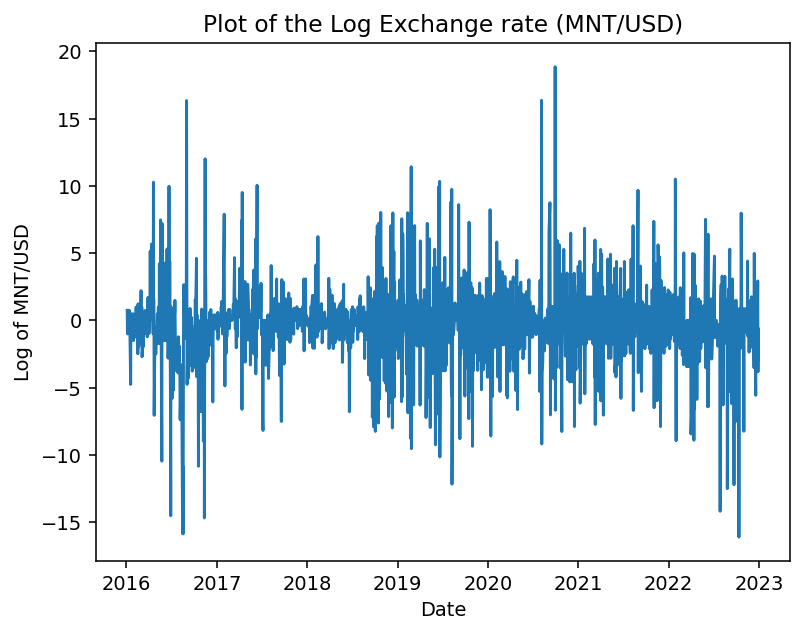

In [67]:
# Plot the log exchange series
plt.plot(df.log_exchange)
plt.title('Plot of the Log Exchange rate (MNT/USD)')
plt.xlabel('Date')
plt.ylabel('Log of MNT/USD')
plt.rcParams['figure.dpi'] = 140

### Introduce treatment Startdate
- #### I chose January 1 2020 as the treatment start
- #### Data before 2020 would be treated as pre-treatment 
- #### Data from 2020 would be treated as post-treatment 


In [68]:
treatment_date = '2020-01-01'
pre_treat_df = df[df.index < treatment_date]
post_treat_df = df[df.index >= treatment_date]


### FIT THE GARCH MODEL
- #### GARCH model with Inflation as the exogenous variable in the mean process


In [69]:
# Define the model with inflation as the exogenous variable in mean process
garch_model = arch_model(df['log_exchange'], 
                   vol='GARCH', p=1, o=0, q=1, 
                   mean='ARX', lags=1, x=inflation)


In [70]:
garch_fit = garch_model.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 7975600228583957.0
Iteration:      2,   Func. Count:     25,   Neg. LLF: 20743.576365425695
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2818325.475245868
Iteration:      4,   Func. Count:     43,   Neg. LLF: 39374.85640711709
Iteration:      5,   Func. Count:     52,   Neg. LLF: 2789322.289110828
Iteration:      6,   Func. Count:     65,   Neg. LLF: 27890.057393729257
Iteration:      7,   Func. Count:     75,   Neg. LLF: 7191.96405308031
Iteration:      8,   Func. Count:     82,   Neg. LLF: 6860.699217380448
Iteration:      9,   Func. Count:     89,   Neg. LLF: 6150.268202284114
Iteration:     10,   Func. Count:     96,   Neg. LLF: 12240.55757809024
Iteration:     11,   Func. Count:    106,   Neg. LLF: 6582.622620413569
Iteration:     12,   Func. Count:    114,   Neg. LLF: 4524.574289606903
Iteration:     13,   Func. Count:    121,   Neg. LLF: 5151.040690086271
Iteration:     14,   Func. Count:    129,   Neg. LLF: 4492.535

In [71]:
# Print the summary of the model
print(garch_fit.summary())


                          AR-X - GARCH Model Results                          
Dep. Variable:           log_exchange   R-squared:                       0.021
Mean Model:                      AR-X   Adj. R-squared:                  0.020
Vol Model:                      GARCH   Log-Likelihood:               -4311.99
Distribution:                  Normal   AIC:                           8635.98
Method:            Maximum Likelihood   BIC:                           8668.92
                                        No. Observations:                 1790
Date:                Mon, Mar 13 2023   Df Residuals:                     1787
Time:                        11:31:40   Df Model:                            3
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const             -0.0971      0.190     -0

### Forecast Value-at-Risk at 5% confidence level

In [72]:

forecast_horizon = 1
forecast = garch_fit.forecast(horizon=forecast_horizon,
                            x=inflation.iloc[-1:], method='simulation')
volatility = np.sqrt(forecast.variance)
VaR = -volatility * np.percentile(df["log_exchange"], 10)
var_10 = np.percentile(forecast.variance[-1:], 10)
print(forecast)
VaR = -volatility * np.percentile(df["log_exchange"], 10)



In [73]:
print(garch_fit.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:           log_exchange   R-squared:                       0.021
Mean Model:                      AR-X   Adj. R-squared:                  0.020
Vol Model:                      GARCH   Log-Likelihood:               -4311.99
Distribution:                  Normal   AIC:                           8635.98
Method:            Maximum Likelihood   BIC:                           8668.92
                                        No. Observations:                 1790
Date:                Mon, Mar 13 2023   Df Residuals:                     1787
Time:                        11:31:40   Df Model:                            3
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const             -0.0971      0.190     -0

________________________________________________________________________________
## <ins>Question 3: </ins>
   - ### Based on (2), please prepare a plot of conditional distribution curve for a specific date, on which you should indicate the value at risk of 10% in total, both tails. Prepare a summary to interpret this plot.

In [74]:
date_selected = '2021-01-04'
# Conditional Districution Curve----
cond_var = garch_fit.conditional_volatility
# Calculate the 10% VaR
VaR = -1.645 * np.sqrt(cond_var[date_selected])


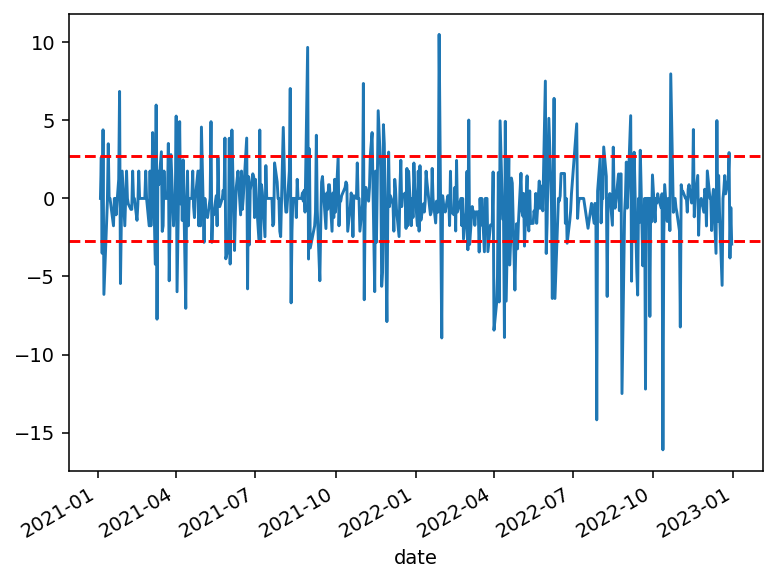

In [75]:
cond_var = garch_fit.conditional_volatility
# Calculate the 10% VaR
VaR = -1.645 * np.sqrt(cond_var[date_selected])

fig, ax = plt.subplots()
df['log_exchange'][date_selected:].plot(ax=ax)
ax.axhline(y=-VaR, color='r', linestyle='--')
ax.axhline(y=VaR, color='r', linestyle='--')
#ax.set_title('Conditional Distribution on 2021-01-04')
#ax.set_xlabel('Date')
#ax.set_ylabel('Log Returns')
plt.show()

43.695181491448814


KeyError: 'x0'

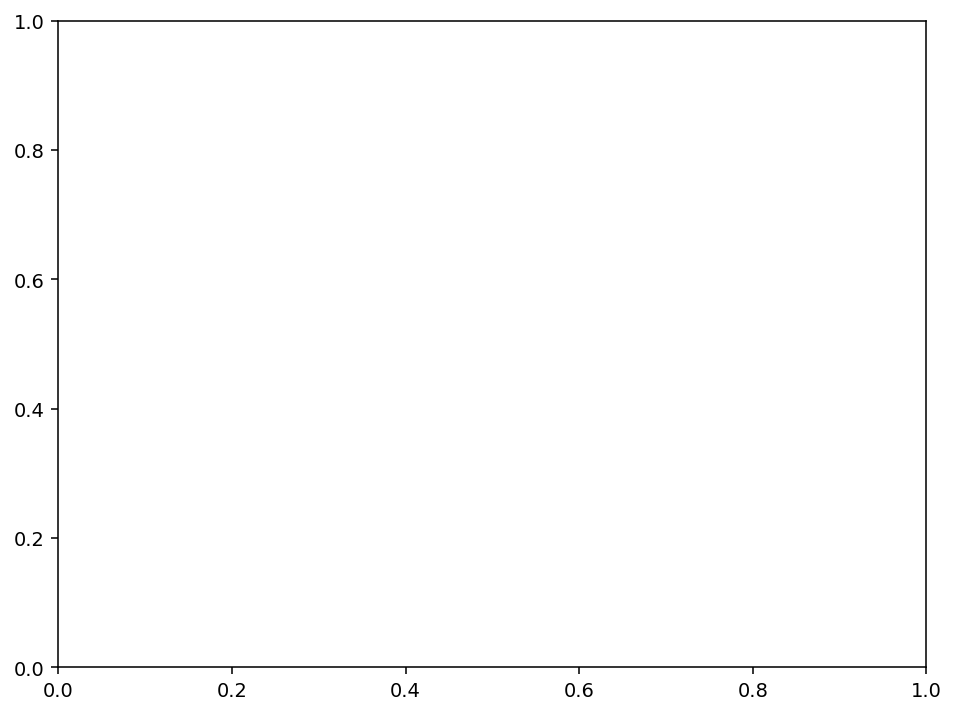

In [76]:
# Plot conditional distribution curve for the specific date
fig, ax = plt.subplots(figsize=(8,6))
x = np.linspace(-5, 5, 100)
y = garch_fit.conditional_volatility[date_selected]* np.sqrt(252)
print(y)
density = np.exp(-(x + garch_fit.params['x0'] *df['inflation'][-1]**2)**2 / (2*y**2)) / (np.sqrt(2*np.pi)*y)
ax.plot(x, density, linewidth=2)
ax.axvline(-var_10, linestyle='--', color='red')
ax.axvline(var_10, linestyle='--', color='red')
ax.set_xlabel('Log Returns')
ax.set_ylabel('Density')
ax.set_title(f'Conditional Distribution on {date_selected}')
plt.show()